Gholamrezadar 2022 ...

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()
sns.set_style('dark')

from tqdm.notebook import trange
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

np.random.seed(2)

from numba import njit

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13284671755122685700
xla_global_id: -1
]


## 3 - Loading the data

In [3]:
# Loading and parsing the data
X_train_df = pd.read_csv('X_train.txt', delim_whitespace=True, header=None)
X_test_df = pd.read_csv('X_test.txt', delim_whitespace=True, header=None)
y_train_df = pd.read_csv('y_train.txt', delim_whitespace=True, header=None)
y_test_df = pd.read_csv('y_test.txt', delim_whitespace=True, header=None)

In [4]:
# Shuffle the data
train_idx = np.random.permutation(X_train_df.index)
X_train_df = X_train_df.reindex(train_idx)
y_train_df = y_train_df.reindex(train_idx)

test_idx = np.random.permutation(X_test_df.index)
X_test_df = X_test_df.reindex(test_idx)
y_test_df = y_test_df.reindex(test_idx)

In [5]:
# Train, valid split
split = 0.8

X_train = X_train_df.iloc[ : int(len(X_train_df)*split),:].reset_index(drop=True)
X_valid = X_train_df.iloc[int(len(X_train_df)*split) : ,:].reset_index(drop=True)

y_train = y_train_df.iloc[ : int(len(y_train_df)*split)].reset_index(drop=True)
y_valid = y_train_df.iloc[int(len(y_train_df)*split) : ].reset_index(drop=True)

In [6]:
# Pandas to numpy
X_train = X_train.to_numpy()
y_train = y_train.to_numpy().flatten()

X_valid = X_valid.to_numpy()
y_valid = y_valid.to_numpy().flatten()

X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy().flatten()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape} \n")

print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape} \n")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape} \n")


X_train shape: (5881, 561)
y_train shape: (5881,) 

X_valid shape: (1471, 561)
y_valid shape: (1471,) 

X_test shape: (2947, 561)
y_test shape: (2947,) 



In [7]:
# Cleanup
del X_train_df, X_test_df, y_train_df, y_test_df

## 4 - MLP

In [8]:
%load_ext tensorboard

In [9]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout

# # We make a function to create the model so that its easy to recreate the model
# # with different hyperparameters.
# def create_model():
#     model = Sequential([
#         Dense(32, activation='relu', input_shape=(X.shape[1],)),
#         Dense(32, activation='relu'),
#         Dense(2, activation='softmax'),
#     ])
#     return model

In [10]:

# tf.keras.utils.plot_model(
#     create_model(), to_file='model.png', show_dtype=True,
#     show_layer_names=True, rankdir='TB', expand_nested=True, dpi=120,
#     layer_range=None
# )


In [11]:

# import datetime

# # Create the model and compile it
# model = create_model()
# model.compile(optimizer='adam',
#             loss='sparse_categorical_crossentropy',
#             metrics=['accuracy'])
# model.summary()


In [12]:

# # Tenserboard
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(
#     log_dir=log_dir, histogram_freq=1)


In [13]:

# # Train the model
# model.fit(x=X_train,
#         y=y_train,
#         epochs=150,
#         validation_split=0.125,
#         callbacks=[tensorboard_callback])


In [14]:

# model.evaluate(X_test, y_test)


In [15]:

# %tensorboard --logdir logs/fit

## 5 - SOM

In [22]:
@njit
def find_winner_inner(rep_x, map):
    dists = np.sum((map - rep_x) ** 2, axis=2)
    winner = np.argmin(dists, axis=None)
    return winner

In [23]:
class SOM:
    def __init__(self, map_size, lr=0.1):
        """
        Args:
            map_size : [map_w, map_h, f=561]
        """
        self.map = np.random.random(size=(map_size[0], map_size[1], map_size[2]))

        self.lr0 = lr
        self.lr = self.lr0

        self.R0 = map_size[0] // 2
        self.R = self.R0

        self.Js = []

    def train(self, X, y, T=1000, error_threshold=10**-20, viz=False):
        # Loss history
        self.Js = []
        for t in trange(T):
            prev_map = self.map.copy()
            # Shuffle X in every iteration
            shuffle_ind = np.random.randint(0, X.shape[0], X.shape[0])
            for i in range(len(X)):
                x = X[shuffle_ind[i], :]
                # Neuron with most compatibilty with x
                winner = self.find_winner(x)
                # Get all neurons in the neighborhood of winner
                NS = self.get_NS(winner)
                # Update weights of all neurons in the neighborhood of winner
                self.update_weights(x, winner, NS, len(X)) 

            # Update learning rate and neighborhood radius (linear decay)
            self.lr = self.lr0 * (1 - t / T)
            self.R = self.R0 * (1 - t / T)


            self.Js.append(np.linalg.norm(prev_map - self.map))

            # if t%1 == 0 or t == T-1:
            print(f"Iteration: {t}, Loss: {self.Js[-1]:.4f}, lr: {self.lr:.4f}, R: {self.R:.4f}")
            
            if viz:
                self.visualize(X, y)
            
            if self.Js[-1] < error_threshold:
                print("MIN CHANGE")
                break

        return self.Js

    def find_winner(self, x):
        rep_x = np.tile(x, (self.map.shape[0], self.map.shape[1], 1))
        winner = np.unravel_index(find_winner_inner(rep_x, self.map), shape=(self.map.shape[0], self.map.shape[1]))
        return winner

    def get_NS(self, winner):
        # NS: Neighborhood strength
        NS = np.zeros((self.map.shape[0], self.map.shape[1]))

        # winner i,j
        iw, jw = winner[0], winner[1]
        
        NS[iw, jw] = 1 # Winner

        # Circular neighborhood
        R = int(self.R)
        for ri in range(-R, R):
            for rj in range(-R, R):
                if 0 <= iw + ri < self.map.shape[0] and 0 <= jw + rj < self.map.shape[1]:
                    NS[iw + ri, jw + rj] = 0 if np.sqrt(ri**2 + rj**2)>R else 1/(1+np.sqrt(ri**2 + rj**2))
        
        return NS

    def update_weights(self, x, winner, n_strength, X_len):
        # Note: n_strength is already W*H we just need to make it W*H*f
        NS = np.tile(n_strength, (self.map.shape[2], 1, 1)).transpose()

        # Difference between inputs and neurons
        rep_x = np.tile(x, (self.map.shape[0], self.map.shape[1], 1))
        Delta = rep_x - self.map

        # Update weights
        self.map = self.map + (self.lr/X_len) * np.multiply(NS, Delta)

    def visualize(self, X, y):
        self.scores = np.zeros(shape=(self.map.shape[0], self.map.shape[1], 7)) # 6 classes + 1 dead
        for i in range(len(X)):
            x = X[i, :]
            winner = self.find_winner(x)
            iw, jw = winner[0], winner[1]
            self.scores[iw, jw, y[i]] += 1
        
        top_class = np.argmax(self.scores, axis=2)
        plt.imshow(top_class, cmap='twilight', vmin=0, vmax=7) #gnuplot, twilight, Set1, inferno
        plt.show()
        
        return self.scores
    
    def plot_loss(self):
        plt.plot(self.Js)
        plt.title("Training Loss")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.show()
    
    def extract_features(self, x):
        rep_x = np.tile(x, (self.map.shape[0], self.map.shape[1], 1))
        dists = np.sum((self.map - rep_x) ** 2, axis=2)
        return 1/(1+dists)

In [24]:
%%prun

np.random.seed(3)

som_net = SOM(map_size=(9,9,X_valid.shape[1]), lr=0.5)

# Loss
Js = som_net.train(X_valid, y_valid, T=100, viz=False)

som_net.plot_loss()

# Visualize
scores = som_net.visualize(X_valid, y_valid)

# Feature Extraction
# x = X_train[0, :]
# features = som_net.extract_features(x)
# plt.imshow(features)
# plt.title("Feature Extraction")
# plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 0, Loss: 15.5889, lr: 0.5000, R: 4.0000
Iteration: 1, Loss: 13.5509, lr: 0.4950, R: 3.9600
Iteration: 2, Loss: 10.7533, lr: 0.4900, R: 3.9200
Iteration: 3, Loss: 9.5577, lr: 0.4850, R: 3.8800
Iteration: 4, Loss: 8.3999, lr: 0.4800, R: 3.8400
Iteration: 5, Loss: 7.4322, lr: 0.4750, R: 3.8000
Iteration: 6, Loss: 6.4896, lr: 0.4700, R: 3.7600
Iteration: 7, Loss: 5.8598, lr: 0.4650, R: 3.7200
Iteration: 8, Loss: 5.2413, lr: 0.4600, R: 3.6800
Iteration: 9, Loss: 4.7933, lr: 0.4550, R: 3.6400
Iteration: 10, Loss: 4.4447, lr: 0.4500, R: 3.6000
Iteration: 11, Loss: 4.0347, lr: 0.4450, R: 3.5600
Iteration: 12, Loss: 3.7061, lr: 0.4400, R: 3.5200
Iteration: 13, Loss: 3.5172, lr: 0.4350, R: 3.4800
Iteration: 14, Loss: 3.3375, lr: 0.4300, R: 3.4400
Iteration: 15, Loss: 3.1328, lr: 0.4250, R: 3.4000
Iteration: 16, Loss: 2.9472, lr: 0.4200, R: 3.3600
Iteration: 17, Loss: 2.7323, lr: 0.4150, R: 3.3200
Iteration: 18, Loss: 2.5528, lr: 0.4100, R: 3.2800
Iteration: 19, Loss: 2.4279, lr: 0.405

KeyboardInterrupt: 

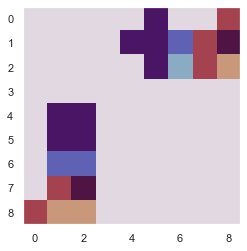

         247702 function calls (243107 primitive calls) in 0.489 seconds

   Ordered by: internal time
   List reduced from 1291 to 129 due to restriction <0.1>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1471    0.101    0.000    0.254    0.000 4134594492.py:50(find_winner)
     4590    0.064    0.000    0.064    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     2942    0.036    0.000    0.036    0.000 {method 'repeat' of 'numpy.ndarray' objects}
9864/9382    0.016    0.000    0.175    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
     1471    0.015    0.000    0.060    0.000 shape_base.py:1171(tile)
     3599    0.008    0.000    0.073    0.000 fromnumeric.py:69(_wrapreduction)
        1    0.007    0.007    0.489    0.489 4134594492.py:85(visualize)
8219/5813    0.006    0.000    0.009    0.000 artist.py:290(stale)
       70    0.005    0.000    0.005    0.000 {method 'set_text' of 'matplotlib.ft2font.FT2Font' obj

In [ ]:
scores = som_net.visualize(X_valid, y_valid)

In [ ]:
np.max(scores, axis=2)
scores[:2, :2]

array([[[  0.,   0.,   0.,   2.,   0.,   0.,   0.],
        [  0., 182.,  81.,  70., 122., 120., 156.]],

       [[  0.,  66., 121., 134., 147., 163., 107.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.]]])

In [ ]:
# new_scores = np.where(np.max(scores, axis=2)==0, 6, np.argmax(scores, axis=2))
# new_scores

In [ ]:
# plt.imshow(new_scores, cmap='twilight', vmin=0, vmax=7) #gnuplot, twilight, Set1, inferno

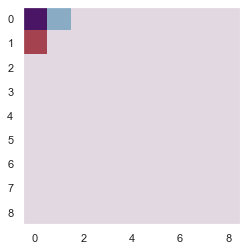

In [ ]:
top_class = np.argmax(scores, axis=2)
# top_class[0,0] = 0
# top_class[0,1] = 1
# top_class[0,2] = 2
# top_class[0,3] = 3
# top_class[0,4] = 4
# top_class[0,5] = 5
# top_class[0,6] = 6
plt.imshow(top_class, cmap='twilight', vmin=0, vmax=7) #gnuplot, twilight, Set1, inferno

In [ ]:
top_class

array([[0, 1, 2, 3, 4, 5, 6, 0, 0],
       [5, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

## 6 - MLP with SOM extracted features